# Improving network performance on unbalanced data via augmentation 🦇
__Author:__ Jonas Bengt Carina Håkansson

__Date:__ 20220831

## Background
Read the [DeepLabCut Blog post](https://deeplabcut.medium.com/balancing-bats-d3c5bcfb71e1) about how one can solve unbalanced data with flipping-keypoint augmentation, then see below for the process and code to do so!

## The dataset
This dataset consists of videos of bats flying freely at the [Austin Bat Refuge](https://austinbatrefuge.org/). The videos were shot by Dr. Aaron Corcoran, Head of the [Sensory & Aerial Ecology lab](https://sonarjamming.com/) at the University of Colorado, Colorado Sprungs (UCCS) in 2020. The dataset is comprised of 26 video triplets. Each triplet consists of three videos depicting the same bat flight from different angles.

The videos have been partially digitized in [DLTdv](https://github.com/tlhedrick/dltdv) after which custom MATLAB code has been used to extract the digitized frames and coordinates in a format that DeepLabCut can read.

## Background
This text documents my experience in using data augmentation to improve the accuracy of DeepLabCut in tracking bodyparts of the bats in the videos during my time as a [DeepLabCut AI Resident](https://www.deeplabcutairesidency.org/) during the summer of 2022.

## Creating the DeepLabCut project
We start by defining the path we will be working in. Then we create the project.

In [ ]:
import deeplabcut

project_folder = "/home/user/projects/" #the folder in which the DLC project will be created
deeplabcut.create_new_project(
            project='bat_augmentation_austin_2020_bat_data',
            experimenter='DLC',
            videos=['/home/user/dummyVideos/'],
            working_directory=project_folder

        )

## Edit the config file

Now that the project is created we need to modify our project config file. Open config.yaml in the project folder.

The config file can be modified with any text editor, but I will do it via Python commands to highlight the possibility of automating this process.

![what to change in the config file](https://images.squarespace-cdn.com/content/v1/57f6d51c9f74566f55ecf271/1661950854851-BEJVFJYTWOZDXFFF1091/config001_videos_and_bodyparts.png?format=750w)

*The list of videos and the list of bodyparts need to change to reflect the actual videos and bodyparts*

In [ ]:
#define config file
config_path = "/home/user/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/config.yaml"

#import tools for modifying our config file
from deeplabcut.utils.auxiliaryfunctions import read_config, edit_config


![Bat bodyparts](https://images.squarespace-cdn.com/content/v1/57f6d51c9f74566f55ecf271/1661950854711-GE81YU6I16GB4EXYLGWG/bat_markers.png?format=750w)
*The locations of the labels/bodyparts on the bats.*

In [ ]:
# replace the default list of bodyparts with a list of the parts that we have actually digitized
edit_config(config_path,{"bodyparts":['t3L', 'wstL', 't5L', 'elbL', 'shdL', 'ankL', 'nl', 'str', 'lmb', 'shdR', 'ankR', 'elbR', 'wstR', 't5R', 't3R', 'tail']})

In [ ]:
#fetch the list of videos from an older project using the same videos
videolist = read_config("/home/user/projects/old_project-DLC-2022-08-03/config.yaml")["video_sets"]
edit_config(config_path,{'video_sets':videolist})

## Convert training data to DLC format
Since this data was labeled outside of DeepLabCut, we first used our own code to convert it into csv formatted csv files, we then use the function ```convertcsv2h5``` to convert these csv:s into h5 files that DeepLabCut can read.

After doing this, I like to use the functgion ```check_labels``` to make sure that the conversion was succesful. 

In [ ]:
# Convert training data into the DeepLabCut format
import deeplabcut
deeplabcut.convertcsv2h5(config_path, userfeedback=False)

# Check labels (sanity check)
deeplabcut.check_labels(config_path)

![Labeled frame](https://images.squarespace-cdn.com/content/v1/57f6d51c9f74566f55ecf271/1661950852823-0AF8A8L896O58A94UXIV/094_093_089_val_AS_c2_frame325_bodypart.png?format=500w)

*The labels appear to be in the right place.*

## Structuring the project for testing

Since bats are such a challenging animal to automatcially digitize, in my lab, we've been relying on what I call "refining" to improve DLC accuracy. This just means that for each video that we want to analyze, we first digitize a few frames from it and include those frames as training data for the DeepLabCut network.

We typically digitize approximately one frame per wingbeat. For a wingbeat frequency of 15 and a framerate of 800, this means approximately every 50th frame. For a lower framerate, say 400, we instead need to digitize every 50th frame. This is obviously less labour than digitizing every frame, but the workflow still scales poorly with increased aquisition. Therefore, I want to reduce the required amount of manual digitization. The challenge I've set myself is therefore this - **to use augmentation to match or beat the accuracy of refining**.

### Test data
I randomly chose seven digitized triplets of videos for testing. Every 50th frame of these will be used for testing.

### Treatments
I will use two "treatments" for testing. Firstly, I simply test how increasing the amount of training data affects accuracy. Secondly, I test how adding refining data affects accuracy. The result is a four permutations of treatments in total, sorted into four shuffles as shown in *table 1*.

#### Refining
The seven testing video triplets have had every 25th frame digitized. Frames 50, 100, 150, ... is used for testing. In this treatment, frames 25, 75, 175, ... will be used for used as training data, i.e. refining. I call the networks not trained on refining data OOD for out of domain and the ones traioned on refining data Ref for refining.

#### Amount of base training data
Subtracting the seven testing video triplets, I'm left with 19 (57 videos in total). I then randomly split these into two groups of 9 and 10. I will either train on only 10 of these video triplets, or on all 19. I call these treatments "half" and "full".

This treatment might not seem relevant for figuring out how augmentation affects performance, and in truth, I chose to perform this test to answer another question, but you will see that the results of this test are very relevant to the challenge written in bold above.

I will refer to training data from the 19 videos not tested on as "base training data".

*Table 1: The two treatments result in four permutations, organized in four shuffles.*
|       |**Half**|**Full**|
|-------|--------|--------|
|**OOD**|shuffle1|shuffle2|
|**Ref**|shuffle3|shuffle4|

### Training data indices
By default, DeepLabCut assumes that we want to randomly divide the data into training and testing data. But for testing, you might want more control of this. Therefore, we will manually define which frames are for training and which are for testing. More on this later, but for now, we need to create a dummy training dataset as this will make DeepLabCut create a nice list of all the frames in the dataset.

In [ ]:
# in case we restarted the kernel or something, let's make
# sure deeplabcut is imported and the config_path defined
import deeplabcut

config_path = "/home/user/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/config.yaml"

# Dummy training dataset to get indexes and so on from later
deeplabcut.create_training_dataset(config_path, Shuffles=[99])

### Define shuffles
Now that we have created a dummy training dataset, we can parse its list of files and add the indices of the ones we want to train on to the list of training data indices, and the ones we want to test on to the test data indices.

This is easy to do since when I converted our training data from DLTdv, I made sure to name the folders with endings indicating where they belong with regards to our treatments.

The naming convention looks like this:
- The folders that end with "_A" belong in the first half of the training data, that means that when we train on "half" the data, we only train on these.
- The folders that end with "_B" belong in the second half of the training data, that means that when we train on the "full" data, we train on these as well as the ones from the first half.
- The folders that end with "_25_ref" contain the refining frames from the 7 test videos, so when we train with the "Ref" data, we include these as training data.
- The folders that end with "_50_test" are from the 7 test videos and they are always used as testing data.

So by parsing the list of frames from the dataset, we can create our four shuffles as specified in *table 1* and in the list above.

In [ ]:
# in case we restarted the kernel or something, let's make
# sure deeplabcut is imported and the config_path defined
import deeplabcut

config_path = "/home/user/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/config.yaml"

# We need pandas for creatig a nice list to parse
import pandas as pd

# Read the h5 file containing all the frames, (project_folder/training-datasets/iteration-0/UnaufmentedDataSet_project_folder/CollectedData_LabelerName.h5)
df = pd.read_hdf('/home/user/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/training-datasets/iteration-0/UnaugmentedDataSet_bat_augmentation_austin_2020_bat_dataAug18/CollectedData_DLC.h5')

image_paths = df.index.to_list() # turn dataframe into list

# create empty lists for putting testing and training indices in
test_inds = []
train_inds = []

# train on half, test data is OOD, shuffle 1
test_inds = []
train_inds = []
for i, path in enumerate(image_paths):
    if str(path[1]).endswith("_A"):
        train_inds.append(i)
    elif str(path[1]).endswith("_50_test"):
        test_inds.append(i)

deeplabcut.create_training_dataset(
    config_path,
    Shuffles=[1],
    trainIndices=[train_inds],
    testIndices=[test_inds],
    net_type="resnet_50",
    augmenter_type="../imagesaug"
)

# train on half+ref, shuffle 2
test_inds = []
train_inds = []
for i, path in enumerate(image_paths):
    if str(path[1]).endswith("_A"):
        train_inds.append(i)
    elif str(path[1]).endswith("_25_ref"):
        train_inds.append(i)
    elif str(path[1]).endswith("_50_test"):
        test_inds.append(i)

deeplabcut.create_training_dataset(
    config_path,
    Shuffles=[2],
    trainIndices=[train_inds],
    testIndices=[test_inds],
    net_type="resnet_50",
    augmenter_type="../imagesaug"
)

# train on full, test data is OOD, shuffle 3
test_inds = []
train_inds = []
for i, path in enumerate(image_paths):
    if str(path[1]).endswith("_A"):
        train_inds.append(i)
    elif str(path[1]).endswith("_B"):
        train_inds.append(i)
    elif str(path[1]).endswith("_50_test"):
        test_inds.append(i)

deeplabcut.create_training_dataset(
    config_path,
    Shuffles=[3],
    trainIndices=[train_inds],
    testIndices=[test_inds],
    net_type="resnet_50",
    augmenter_type="../imagesaug"
)

# train on full+ref, shuffle 4
test_inds = []
train_inds = []
for i, path in enumerate(image_paths):
    if str(path[1]).endswith("_A"):
        train_inds.append(i)
    elif str(path[1]).endswith("_B"):
        train_inds.append(i)
    elif str(path[1]).endswith("_25_ref"):
        train_inds.append(i)
    elif str(path[1]).endswith("_50_test"):
        test_inds.append(i)

deeplabcut.create_training_dataset(
    config_path,
    Shuffles=[4],
    trainIndices=[train_inds],
    testIndices=[test_inds],
    net_type="resnet_50",
    augmenter_type="../imagesaug"
)

## Using modelprefixes to keep track of augmentations

Now we are using the shuffles to keep track of the training data used for our different networks, but we will also be trying different augmentatns. So how do we keep track of that? We could just keep making new shuffles and keep a list of what shuffle is what, but that can quickly become unwieldy.

Instead, we can use modelprefixes. They provide a way to structure a DLC project into something like subprojects. Basically, if you copy a dlc-model folder (in my case, found in ```/home/user/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/dlc-models/iteration-0```) into a subfolder in the project, you can then interact with the copied dlc model by using the argument ```modelprefix```.

Say, for example, that I want to try a more aggressive motion blur augmentation, then I could create a folder called ```extra_blurry``` in my project, copy the dlc-models into it, and then change the pose_cfg.yaml files that contain the augmentation parameters to increase the motion blur augmentation.

I would then train the model with this command:
```
deeplabcut.train_network(
    config_path,
    shuffle=shuffle_number,
    modelprefix='extra_blurry',
    )
```

Our first networks will be trained with the default augmentation, but it's still useful to create a folder for them as we will want to copy the dlc-models in the root project folder for later augmentations, so it makes sense to keep those clean and do all training with model prefixes. 

### Regarding trainingsetindex
Before we can create our subfolders, we need to spend a minute on the trainingset indices.

We often use different splits between training and testing data. This is a number < 1 that sets the proportion of the training dataset that should be used for training and testing. The default is 0.95, meaning 95% is used for training, and 5% for testing. This can be either be specified in the config.yaml file or deduced automatically by DeepLabCut if we manually specify the training and testing indices (like we did). In the case of the latter, the split is indicated by the filenames of the the files in the training-dataset folder in the project folder. In my case this would be:
```
/home/user/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/training-datasets/iteration-0/UnaugmentedDataSet_bat_augmentation_austin_2020_bat_dataAug18
```

Let's look at the contents of that folder to deduce the training splits.

In [1]:
import os
files = os.listdir("/home/user/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/training-datasets/iteration-0/UnaugmentedDataSet_bat_augmentation_austin_2020_bat_dataAug18")
print(*files,sep='\n')

Documentation_data-bat_augmentation_austin_2020_bat_data_88shuffle51.pickle
bat_augmentation_austin_2020_bat_data_DLC88shuffle3.mat
bat_augmentation_austin_2020_bat_data_DLC80shuffle1.mat
bat_augmentation_austin_2020_bat_data_DLC88shuffle52.mat
Documentation_data-bat_augmentation_austin_2020_bat_data_80shuffle1.pickle
CollectedData_DLC.h5
CollectedData_DLC.csv
bat_augmentation_austin_2020_bat_data_DLC89shuffle4.mat
Documentation_data-bat_augmentation_austin_2020_bat_data_88shuffle3.pickle
bat_augmentation_austin_2020_bat_data_DLC84shuffle2.mat
Documentation_data-bat_augmentation_austin_2020_bat_data_84shuffle2.pickle
Documentation_data-bat_augmentation_austin_2020_bat_data_89shuffle4.pickle
bat_augmentation_austin_2020_bat_data_DLC95shuffle99.mat
Documentation_data-bat_augmentation_austin_2020_bat_data_88shuffle52.pickle
bat_augmentation_austin_2020_bat_data_DLC88shuffle51.mat
Documentation_data-bat_augmentation_austin_2020_bat_data_95shuffle99.pickle


I've worked a bit on other stuff in this project, so there is some stuff here we need not consider (51 and 52)- But we see files related to shuffles 1 to 4. Let's focus on the .mat files:
- bat_augmentation_austin_2020_bat_data_DLC80shuffle1.mat
- bat_augmentation_austin_2020_bat_data_DLC84shuffle2.mat
- bat_augmentation_austin_2020_bat_data_DLC88shuffle3.mat
- bat_augmentation_austin_2020_bat_data_DLC89shuffle4.mat

Not that "DLC" here refers to the scorer for the training data, so if you used the scorer name "StephinMerritt", your shuffle1 file name could be "crocodiles_galloping_2023_StephinMerritt95shuffle1.mat".

Anyway, we see that there are numbers between the scorer name and the shuffle name, these represent the fraction of the training data compared to the training data plus the testing data.

So for shuffle 1, of the data used, 80% is used as training data, for shuffle 2, that number is insead 84%, and so on. These numbers are called training fractions.

In config.yaml, there is a property called ```TrainingFraction```. This is a list of the training fractions used in the project. In this project, that list needs to be changed to look like this:

![TrainingFraction](https://images.squarespace-cdn.com/content/v1/57f6d51c9f74566f55ecf271/1661950855466-W5BOH6B4JJCO4M6RNVFG/config002_TrainingFraction.png?format=1000w)

When we then reference a shuffle, we also need to reference the corresponding training fraction, this is used by specifying the parameter ```trainingsetindex```, and note that we start counting from zero. So for each of our shuffles, the index of the training fraction is one smaller than the shuffle number.

With all that clarified, let's now create our first project subfolder/modelprefix.

In [3]:
# in case we restarted the kernel or something, let's make
# sure deeplabcut is imported and the config_path defined
import deeplabcut

config_path = '/home/user/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/config.yaml'

# we also need the package os for folder manipulation
import os
# and shutil for copying files
import shutil

#import tools for reading our config file
from deeplabcut.utils.auxiliaryfunctions import read_config

# Number and name for our model folder
model_number = 0
modelprefix_pre = 'data_augm'
daug_str = 'base'

# Get config as dict and associated paths
cfg = read_config(config_path)
project_path = cfg["project_path"] # or: os.path.dirname(config_path) #dlc_models_path = os.path.join(project_path, "dlc-models")
training_datasets_path = os.path.join(project_path, "training-datasets")

# Define shuffles
shuffles = [1,2,3,4]
trainingsetindices = [0, 1, 2, 3]

# Get train and test pose config file paths from base project, for each shuffle
list_base_train_pose_config_file_paths = []
list_base_test_pose_config_file_paths = []
for shuffle_number, trainingsetindex in zip(shuffles, trainingsetindices):
    base_train_pose_config_file_path_TEMP,\
    base_test_pose_config_file_path_TEMP,\
    _ = deeplabcut.return_train_network_path(config_path,
                                            shuffle=shuffle_number,
                                            trainingsetindex=trainingsetindex)  # base_train_pose_config_file
    list_base_train_pose_config_file_paths.append(base_train_pose_config_file_path_TEMP)
    list_base_test_pose_config_file_paths.append(base_test_pose_config_file_path_TEMP)

# Create subdirs for this augmentation method
model_prefix = '_'.join([modelprefix_pre, "{0:0=2d}".format(model_number), daug_str]) # modelprefix_pre = aug_
aug_project_path = os.path.join(project_path, model_prefix)
aug_dlc_models = os.path.join(aug_project_path, "dlc-models", )

# make the folder for this modelprefix
try:
    os.mkdir(aug_project_path)
except OSError as error:
    print(error)
    print("Skipping this one as it already exists")

# Copy base train pose config file to the directory of this augmentation method
for j, (shuffle, trainingsetindex) in enumerate(zip(shuffles,trainingsetindices)):
    one_train_pose_config_file_path,\
    one_test_pose_config_file_path,\
    _ = deeplabcut.return_train_network_path(config_path,
                                            shuffle=shuffle,
                                            trainingsetindex=trainingsetindex,
                                            modelprefix=model_prefix)
    
    # make train and test directories for this subdir
    os.makedirs(str(os.path.dirname(one_train_pose_config_file_path))) # create parentdir 'train'
    os.makedirs(str(os.path.dirname(one_test_pose_config_file_path))) # create parentdir 'test
    
    # copy test and train config from base project to this subdir
    # copy base train config file
    shutil.copyfile(list_base_train_pose_config_file_paths[j],
                        one_train_pose_config_file_path) 
    # copy base test config file
    shutil.copyfile(list_base_test_pose_config_file_paths[j],
                        one_test_pose_config_file_path)


## Edit pose_cfg.yaml
We will also edit the settings for this network to use the adam optimizer.

In [ ]:

model_prefix = 'data_augm_00_base'

## Initialise dict with additional edits to train config: optimizer
train_edits_dict = {}
dict_optimizer = {'optimizer':'adam',
    'batch_size': 8, # the gpu I'm using has plenty of memory so batch size 8 makes sense
    'multi_step': [[1e-4, 7500], [5 * 1e-5, 12000], [1e-5, 150000]]} # if no yaml file passed, initialise as an empty dict
train_edits_dict.update({'optimizer': dict_optimizer['optimizer'], #'adam',
    'batch_size': dict_optimizer['batch_size'],
    'multi_step': dict_optimizer['multi_step']})

for shuffle, trainingsetindex in zip(shuffles,trainingsetindices):
    one_train_pose_config_file_path,\
    _,\
    _ = deeplabcut.return_train_network_path(config_path,
                                            shuffle=shuffle,
                                            trainingsetindex=trainingsetindex,
                                            modelprefix=model_prefix)

    edit_config(str(one_train_pose_config_file_path), train_edits_dict)

## Train networks
Now we need to train our four shuffles. This will take several hours.

In [ ]:
import deeplabcut
# define config path and model prefix
config_path='/home/user/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/config.yaml'
model_prefix = 'data_augm_00_base'

# the computer I'm working on has several gpus, here I used the third one.
gputouse=3

# define shuffles and trainingsetindices
shuffles = [1,2,3,4]
trainingsetindices = [0,1,2,3]

# loop over shuffles and train each
for shuffle, trainingsetindex in zip(shuffles, trainingsetindices):
    deeplabcut.train_network(
        config_path,
        shuffle=shuffle,
        modelprefix=model_prefix,
        gputouse=gputouse,
        trainingsetindex=trainingsetindex,
        max_snapshots_to_keep=3, # training for 150000 iterations so let's save 50, 100, and 150.
        saveiters=50000
    )

# Perform evaluation
Aftrer training the networks, we need to test how they perform. To do that, we first need to evaluate them using the buil-in DeepLabCut method ```evaluate_network```. By default this will evaluate the last snapshot, in our case, this means that the network will be evaluated after 150k iterations, but we want to know how well it does at 50k and 100k too, so let's edit our config file to test all saved snapshot.




In [ ]:
# in case we restarted the kernel or something, let's make
# sure deeplabcut is imported and the config_path defined
import deeplabcut

config_path = '/home/juser/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/config.yaml'

from deeplabcut.utils.auxiliaryfunctions import read_config, edit_config

edit_config(config_path,{'snapshotindex':'all'})

Now we can evaluate the all three snapshots of all three shuffles. Remember that each shuffle has a different ```trainingsetindex```, so we need to perform the evaluations in a loop.

In [ ]:
import deeplabcut
config_path = "/home/user/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/config.yaml"
model_prefix = 'data_augm_00_base'
Shuffles = [1,2,3,4]
trainingsetindices = [0,1,2,3]

for shuffle, trainingsetindex in zip(Shuffles,trainingsetindices):
    deeplabcut.evaluate_network(config_path, modelprefix = model_prefix, Shuffles = [shuffle], trainingsetindex=trainingsetindex)

### Get data for plotting and statistical comparison
The ```evaluate_network``` function calculates the euclidian distances between predicted points and groundtruth (i.e. human labels), but it only shows the average for that snapshot and shuffle over all the test data. What we want are long lists of the distances between ground truth points and predicted points. That way, on top of calculating the average, we can also perform stastistical testing.

We will use a function I wrote called ```getErrorDistribution``` to get the list mentioned above. We will do this for each shuffle.

In [ ]:
# in case we restarted the kernel or something, let's make
# sure deeplabcut is imported and the config_path defined
import deeplabcut

config_path = "/home/user/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/config.yaml"
model_prefix = 'data_augm_00_base'
Shuffles = [1,2,3,4]
trainingsetindices = [0,1,2,3]

# We need pandas for creatig a nice list to parse
import pandas as pd

import sys
sys.path.append('..') #my python file for this function is stored in the parent forlder as I'm running this
from getErrorDistribution import getErrorDistribution #import the getErrorDistribution function
import numpy as np

# Read the h5 file containing all the frames, (project_folder/training-datasets/iteration-0/UnaufmentedDataSet_project_folder/CollectedData_LabelerName.h5)
df = pd.read_hdf('/home/user/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/training-datasets/iteration-0/UnaugmentedDataSet_bat_augmentation_austin_2020_bat_dataAug18/CollectedData_DLC.h5')

image_paths = df.index.to_list() # turn dataframe into list

# get test indices
test_inds = []
for i, path in enumerate(image_paths):
    if str(path[1]).endswith("_50_test"):
        test_inds.append(i)

error_distributions = []
error_distributions_pcut = []

for shuffle, trainFractionIndex in zip(Shuffles,trainingsetindices):
   error_distributions_temp = []
   error_distributions_pcut_temp = []
   for snapshot in [0,1,2]: #we saved three snapshots, one at 50k iteratinos, one at 100k, and one at 150k
      (
            ErrorDistribution_all,
            ErrorDistribution_test,
            ErrorDistribution_train,
            ErrorDistributionPCutOff_all,
            _,
            _
      )  = getErrorDistribution(
            config_path,
            shuffle=shuffle,
            snapindex=snapshot,
            trainFractionIndex = trainFractionIndex,
            modelprefix = model_prefix
      )
      error_distributions_temp.append(ErrorDistribution_all.iloc[test_inds].values.flatten())
      error_distributions_pcut_temp.append(ErrorDistributionPCutOff_all.iloc[test_inds].values.flatten())
   error_distributions.append(error_distributions_temp)
   error_distributions_pcut.append(error_distributions_pcut_temp)
error_distributionsb = np.array(error_distributions) # array with dimensions [shuffle, snapshot, frames]
error_distributions_pcut = np.array(error_distributions_pcut) # array with dimensions [shuffle, snapshot, frames]

Text(0, 0.5, 'Error (px)')

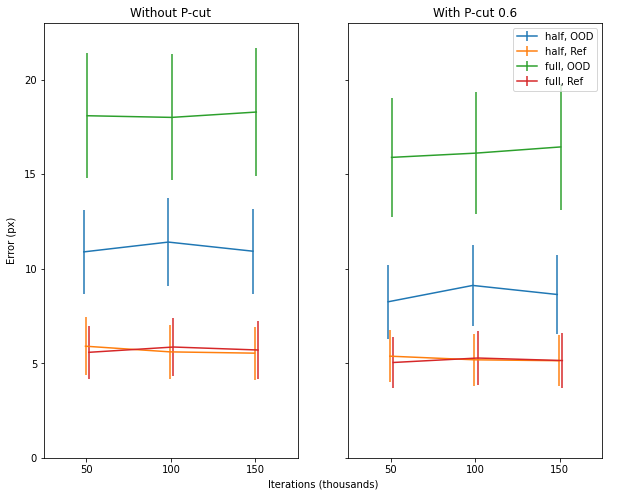

In [19]:
import matplotlib.pyplot as plt

fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_figheight(8)
fig.set_figwidth(10)

for shuffle in [0,1,2,3]: #we start counting at 0, so for now, let's consider each index one less
    ax1.errorbar(np.array([50,100,150])-1.5+shuffle,np.nanmean(error_distributions[shuffle,:],axis=1), np.nanstd(error_distributions[shuffle,:],axis=1)/len(test_inds)**.5)
    ax2.errorbar(np.array([50,100,150])-1.5+shuffle,np.nanmean(error_distributions_pcut[shuffle,:],axis=1), np.nanstd(error_distributions_pcut[shuffle,:],axis=1)/len(test_inds)**.5)

ax1.set_xticks([50, 100, 150])
ax2.set_xticks([50, 100, 150])
ax1.set_xlim([25,175])
ax2.set_xlim([25,175])
ax1.set_ylim([0,23])
ax2.set_ylim([0,23])
ax1.set_title("Without P-cut")
ax2.set_title("With P-cut 0.6")
ax2.set_yticklabels([])
ax2.legend(["half, OOD","half, Ref","full, OOD", "full, Ref"])

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
## hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Iterations (thousands)")
plt.ylabel("Error (px)")



## Interpret plot
Just looking at the plot, a few things seem clear, let's start with the obvious and least surprising. By training a network on a subset of frames of the videos to be analyzed, we really improve accuracy. When doing this, i.e. when refining, increasing the ammount of training data, i.e. frames not belonging to the videos to be analyzed, has little effect on accuracy.

But surprisingly, when not refining, it appears that increasing the amount of training data can worsen performance. What's going on? We will get back to this later, but for now, let's just confirm my points here with some statistical testing.

For the statistical comparison, we'll use a paired Wilcoxon ranked sum test, since we can't assume the data to be normally distributed. We'll do this for the set of errors with P-cut filter applied since doing it on both would be tedious and I assume most users will use some form of P-cut on their data. Furthermore, I will do the statistical comparison only on  the last snapshot since, again, doing it on all three would be tedious.

In [115]:
import numpy as np
from scipy.stats import wilcoxon

p_value = np.empty((4,4))
p_value[:]=np.NaN

for i in [0,1,2,3]:
    for j in [0,1,2,3]:
        if j<=i: continue
        _, p_value[i,j] = wilcoxon(x = error_distributions_pcut[i,-1,:], y = error_distributions_pcut[j,-1,:],nan_policy='omit')

print(p_value)

[[           nan 5.59096117e-09 2.88311009e-05 2.50433310e-28]
 [           nan            nan 9.02769266e-15 6.51936856e-10]
 [           nan            nan            nan 5.65209499e-39]
 [           nan            nan            nan            nan]]


## Plot per video
The statistics are in line with expectations, except for regarding the difference between the two refined shuffles (shuffle2: "half, ref" and shuffle4: "full, ref"). The two of them being significantly different surprises me and makes me want to investigate the error distributions more in detail.

To that end, let's plot the error distributions of the four shuffles per camera and per video number. Remember, out seven test video triplets each consist of three videos depicting the same bat flight.

This net has already been evaluated!
This net has already been evaluated!
This net has already been evaluated!
This net has already been evaluated!


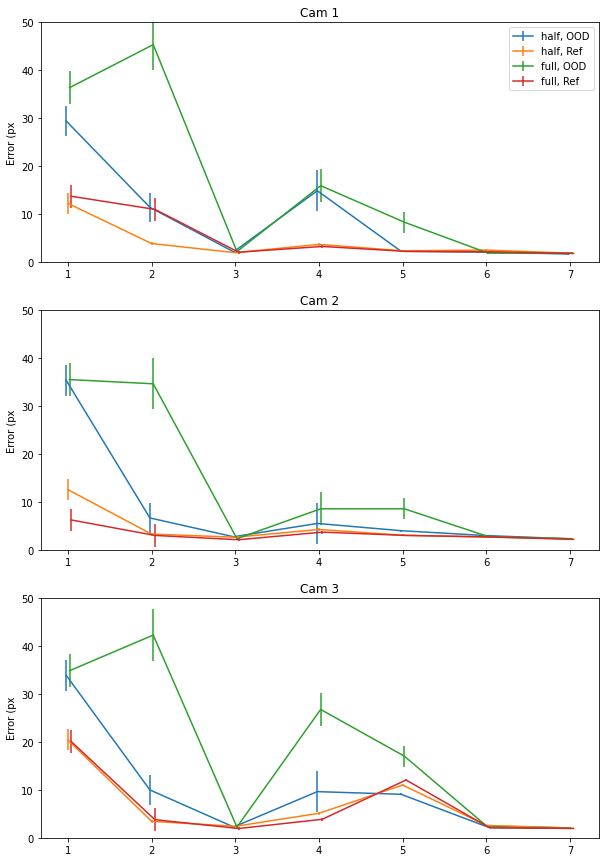

In [135]:
# in case we restarted the kernel or something, let's make
# sure deeplabcut is imported and the config_path defined
import deeplabcut

config_path = "/home/user/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/config.yaml"
model_prefix = 'data_augm_00_base'
Shuffles = [1,2,3,4]
trainingsetindices = [0,1,2,3]

# We need pandas for creatig a nice list to parse
import pandas as pd

import sys
sys.path.append('..') #my python file for this function is stored in the parent forlder as I'm running this
from getErrorDistribution import getErrorDistribution #import the getErrorDistribution function
import numpy as np

# Read the h5 file containing all the frames, (project_folder/training-datasets/iteration-0/UnaufmentedDataSet_project_folder/CollectedData_LabelerName.h5)
df = pd.read_hdf('/home/user/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/training-datasets/iteration-0/UnaugmentedDataSet_bat_augmentation_austin_2020_bat_dataAug18/CollectedData_DLC.h5')

image_paths = df.index.to_list() # turn dataframe into list

# get test indices
test_inds = []
for i, path in enumerate(image_paths):
    if str(path[1]).endswith("_50_test"):
        test_inds.append(i)

# this gives us the paths of our 27 test videos
test_paths = list(set([image_paths[i][1] for i in test_inds]))

#%% sorted so that the corresponding videos have the same index in three lists (one per camera)
test_paths_cam1 =   ['TS5-544-Cam1_2020-06-25_000099Track8_50_test',
                    'TS5-544-Cam1_2020-06-25_000103Track3_50_test',
                    'TS5-544-Cam1_2020-06-25_000104Track3_50_test',
                    'TS5-544-Cam1_2020-06-25_000108Track6_50_test',
                    'TS5-544-Cam1_2020-06-25_000123Track6_50_test',
                    'TS5-544-Cam1_2020-06-25_000128Track2_50_test',
                    'TS5-544-Cam1_2020-06-25_000134Track5_50_test'
                    ]
test_paths_cam2 =   ['IL5-519-Cam2_2020-06-25_000099Track6_50_test',
                    'IL5-519-Cam2_2020-06-25_000103Track3_50_test',
                    'IL5-519-Cam2_2020-06-25_000104Track2_50_test',
                    'IL5-519-Cam2_2020-06-25_000109Track1_50_test',
                    'IL5-519-Cam2_2020-06-25_000124Track9_50_test',
                    'IL5-519-Cam2_2020-06-25_000130Track2_50_test',
                    'IL5-519-Cam2_2020-06-25_000136Track10_50_test'
                    ]
test_paths_cam3 =   ['IL5-534-Cam3_2020-06-25_000095Track14_50_test',
                    'IL5-534-Cam3_2020-06-25_000100Track4_50_test',
                    'IL5-534-Cam3_2020-06-25_000101Track4_50_test',
                    'IL5-534-Cam3_2020-06-25_000106Track3_50_test',
                    'IL5-534-Cam3_2020-06-25_000122Track7_50_test',
                    'IL5-534-Cam3_2020-06-25_000127Track4_50_test',
                    'IL5-534-Cam3_2020-06-25_000133Track9_50_test'
                    ]

nvideos = 7 # number of videos

# get test frame indexes per camera
test_inds_cam1 = [[],[],[],[],[],[],[]]
test_inds_cam2 = [[],[],[],[],[],[],[]]
test_inds_cam3 = [[],[],[],[],[],[],[]]

for i, path in enumerate(image_paths):
    for j in range(nvideos):
        if str(path[1]).__eq__(test_paths_cam1[j]):
            test_inds_cam1[j].append(i)
        elif str(path[1]).__eq__(test_paths_cam2[j]):
            test_inds_cam2[j].append(i)
        elif str(path[1]).__eq__(test_paths_cam3[j]):
            test_inds_cam3[j].append(i)

nshuffles = len(Shuffles)

#pre-allocate matrixes for mean values and standard errors
mean_cam1 = np.zeros([nshuffles,nvideos]) # shuffle x movie
mean_cam2 = np.zeros([nshuffles,nvideos])
mean_cam3 = np.zeros([nshuffles,nvideos])

ste_cam1 = np.zeros([nshuffles,nvideos])
ste_cam2 = np.zeros([nshuffles,nvideos])
ste_cam3 = np.zeros([nshuffles,nvideos])

meanPcut_cam1 = np.zeros([nshuffles,nvideos]) # shuffle x movie
meanPcut_cam2 = np.zeros([nshuffles,nvideos])
meanPcut_cam3 = np.zeros([nshuffles,nvideos])

stePcut_cam1 = np.zeros([nshuffles,nvideos])
stePcut_cam2 = np.zeros([nshuffles,nvideos])
stePcut_cam3 = np.zeros([nshuffles,nvideos])

# %%

for i, shuffle in enumerate(Shuffles):    
    trainFractionIndex = i
    snapshot=-1
    (
        ErrorDistribution_all,
        _,
        _,
        ErrorDistributionPCutOff_all,
        _,
        _
    )  = getErrorDistribution(
        config_path,
        shuffle=shuffle,
        snapindex=snapshot,
        trainFractionIndex = trainFractionIndex,
        modelprefix = model_prefix
    )
    for movie_number in range(7):

        meanPcut_cam1[i,movie_number] = np.nanmean(ErrorDistributionPCutOff_all.values[test_inds_cam1[movie_number]][:])
        stePcut_cam1[i,movie_number] = np.nanstd(ErrorDistributionPCutOff_all.values[test_inds_cam1[movie_number]][:])/(ErrorDistribution_all.values[test_inds_cam1[movie_number]][:].size**.5)

        meanPcut_cam2[i,movie_number] = np.nanmean(ErrorDistributionPCutOff_all.values[test_inds_cam2[movie_number]][:])
        stePcut_cam2[i,movie_number] = np.nanstd(ErrorDistributionPCutOff_all.values[test_inds_cam1[movie_number]][:])/(ErrorDistribution_all.values[test_inds_cam2[movie_number]][:].size**.5)

        meanPcut_cam3[i,movie_number] = np.nanmean(ErrorDistributionPCutOff_all.values[test_inds_cam3[movie_number]][:])
        stePcut_cam3[i,movie_number] = np.nanstd(ErrorDistributionPCutOff_all.values[test_inds_cam1[movie_number]][:])/(ErrorDistribution_all.values[test_inds_cam3[movie_number]][:].size**.5)

fig, (ax1,ax2,ax3) = plt.subplots(3,1)
fig.set_figheight(15)
fig.set_figwidth(10)
for i, shuffle in enumerate(Shuffles):
    
    # to jitter the error bars to keep  them from overlapping
    movie_number = list(range(1,8))
    movie_number = [x - 2/50 + shuffle/50 for x in movie_number]
    
    ax1.errorbar(movie_number,meanPcut_cam1[i,:], stePcut_cam1[i,:,])

    ax2.errorbar(movie_number,meanPcut_cam2[i,:], stePcut_cam2[i,:,])

    ax3.errorbar(movie_number,meanPcut_cam3[i,:], stePcut_cam3[i,:,])

ax1.set_ylim([0, 50])
ax2.set_ylim([0, 50])
ax3.set_ylim([0, 50])
ax1.set_title("Cam 1")
ax2.set_title("Cam 2")
ax3.set_title("Cam 3")
ax1.set_ylabel("Error (px")
ax2.set_ylabel("Error (px")
ax3.set_ylabel("Error (px")
ax1.legend(["half, OOD","half, Ref","full, OOD", "full, Ref"])

## Interpret per video plot
The first thing that becomes clear to me from inspecting this plot is that there are some videos on which all shuffles perform well no matter refining. These would be video 3, 6 and 7. The second thing is that there are instances where "half, ref" does better than "full, ref" and vice versa, which could explain why they are significantly different according to the statistical test performed above, despite their overal means being relatively similar according to the plot of the mean errors on the full error distributions.

## Compare "easy" and "difficult" videos
For shuffle3, "full, OOD", video 1, 2, 4, and 5 does poorly whereas video 3, 6, and 7 do rather well. Why is this? To get an idea of if the videos on which the network does well differs from the one on which it does poorly, we can create labeled frames with the predicted positions of the bodyparts and the correct positions (human labels). This is done with the ```evaluate_network``` function using the ```plotting``` input parameter.

In [ ]:
# in case we restarted the kernel or something, let's make
# sure deeplabcut is imported and the config_path defined
import deeplabcut

config_path = '/home/jusers/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/config.yaml'
model_prefix = 'data_augm_00_base'

# we only want to plot the last snapshot (150k iterations)
from deeplabcut.utils.auxiliaryfunctions import read_config, edit_config

edit_config(config_path,{'snapshotindex':-1})

shuffle = 3
trainingsetindex = 2

deeplabcut.evaluate_network(config_path, modelprefix = model_prefix, Shuffles = [shuffle], trainingsetindex=trainingsetindex, plotting=True)

## Inspect DeepLabCut predictions from evaluations

Inspecting and comparing frames reveal an interesting relationship. It appears the network does well when the bat is flying left-right, and bad when the bat is flying right to left.

The two following example images reveal what I mean.

!["bad"](https://images.squarespace-cdn.com/content/v1/57f6d51c9f74566f55ecf271/1661950853195-EBZD23OVFO0NUSW94CUT/Test-IL5-519-Cam2_2020-06-25_000103Track3_50_test-103_103_100_AS_c2_frame200.png?format=500w)

*The bat is flying from the right to the left, and the network has mistaken the left side of the bat for the right side.*

!["good"](https://images.squarespace-cdn.com/content/v1/57f6d51c9f74566f55ecf271/1661950854190-2VRZO69FEZXJ7GZGFV6J/Test-IL5-519-Cam2_2020-06-25_000130Track2_50_test-128_130_127_AS_c2_frame300.png?format=500w)

*The bat is flying from the left to the right, and the network is accurately predicting all points.

The inspection of the predicted bodypart locations reveal that the low accuracy for some videos is caused by the network mixing up left and right. This could also explain why the performance goes down when we add more data. It appears that the added data results in the network becoming biased towards one flight direction.

## Augment to reduce left-right bias
Our evaluation showed that our network has a bias towards bats flying in one direction. In an attempt to reduce that bias and make the network better at telling left from right independent of flight direction, we will use a left-right flipping augmentaton.

First up, let's make another modelprefix folder in our project. It basically the same code as before but with some minor modifications, I'll highlight the changes.

In [5]:
# in case we restarted the kernel or something, let's make
# sure deeplabcut is imported and the config_path defined
import deeplabcut

config_path = '/home/user/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/config.yaml'

# we also need the package os for folder manipulation
import os
# and shutil for copying files
import shutil

#import tools for reading our config file
from deeplabcut.utils.auxiliaryfunctions import read_config

# Number and name for our model folder
model_number = 1 # CHANGE
modelprefix_pre = 'data_augm'
daug_str = 'fliplr' # CHANGE

# Get config as dict and associated paths
cfg = read_config(config_path)
project_path = cfg["project_path"] # or: os.path.dirname(config_path) #dlc_models_path = os.path.join(project_path, "dlc-models")
training_datasets_path = os.path.join(project_path, "training-datasets")

# Define shuffles
shuffles = [1,2,3,4]
trainingsetindices = [0, 1, 2, 3]

# Get train and test pose config file paths from base project, for each shuffle
list_base_train_pose_config_file_paths = []
list_base_test_pose_config_file_paths = []
for shuffle_number, trainingsetindex in zip(shuffles, trainingsetindices):
    base_train_pose_config_file_path_TEMP,\
    base_test_pose_config_file_path_TEMP,\
    _ = deeplabcut.return_train_network_path(config_path,
                                            shuffle=shuffle_number,
                                            trainingsetindex=trainingsetindex)  # base_train_pose_config_file
    list_base_train_pose_config_file_paths.append(base_train_pose_config_file_path_TEMP)
    list_base_test_pose_config_file_paths.append(base_test_pose_config_file_path_TEMP)

# Create subdirs for this augmentation method
model_prefix = '_'.join([modelprefix_pre, "{0:0=2d}".format(model_number), daug_str]) # modelprefix_pre = aug_
aug_project_path = os.path.join(project_path, model_prefix)
aug_dlc_models = os.path.join(aug_project_path, "dlc-models", )

# make the folder for this modelprefix
try:
    os.mkdir(aug_project_path)
except OSError as error:
    print(error)
    print("Skipping this one as it already exists")

# Copy base train pose config file to the directory of this augmentation method
for j, (shuffle, trainingsetindex) in enumerate(zip(shuffles,trainingsetindices)):
    one_train_pose_config_file_path,\
    one_test_pose_config_file_path,\
    _ = deeplabcut.return_train_network_path(config_path,
                                            shuffle=shuffle,
                                            trainingsetindex=trainingsetindex,
                                            modelprefix=model_prefix)
    
    # make train and test directories for this subdir
    os.makedirs(str(os.path.dirname(one_train_pose_config_file_path))) # create parentdir 'train'
    os.makedirs(str(os.path.dirname(one_test_pose_config_file_path))) # create parentdir 'test
    
    # copy test and train config from base project to this subdir
    # copy base train config file
    shutil.copyfile(list_base_train_pose_config_file_paths[j],
                        one_train_pose_config_file_path) 
    # copy base test config file
    shutil.copyfile(list_base_test_pose_config_file_paths[j],
                        one_test_pose_config_file_path)

## Edit pose_cfg.yaml for fliplr augmentation
As before, we will edit the settings for this network to use the adam optimizer. More importantly, though, we will apply the ```fliplr``` augmentation.

This randomly flips some training frames left and right during training. Now, this alone would lead to worse performance, since we would be training the network to think that the left wing is the right wing, and vice versa. But this augmentation method takes that into account, and in addition to mirroring the image, it also swaps the labels from left to right and vice versa. To accomlish this, we need to supply the pose_cfg.yaml file with a list of which points should be swapped.

The image of a bat outline above shows he locations of the labels/bodyparts on the bats, and from it, it's clear which points should be swapped, all points that arent on the bilateral have a name and end in eithr R or L. So t3R should be swapped with t3L when flipping, and so on.

The labels are these, and in this order:
0. 't3L'
1. 'wstL'
2. 't5L'
3. 'elbL'
4. 'shdL'
5. 'ankL'
6. 'nl'
7. 'str'
8. 'lmb'
9. 'shdR'
10. 'ankR'
11. 'elbR'
12. 'wstR'
13. 't5R'
14. 't3R'
15. 'tail'

So the symmetric pairs are the following:
- t3:   (0, 14)
- wst:  (1, 12)
- t5:   (2, 13)
- elb:  (3, 11)
- shd:  (4, 9)
- ank:  (5, 10)

Now, let's edit the ```pose_cfg.yaml``` accordingly.


In [7]:
#import tools for changing our config file
from deeplabcut.utils.auxiliaryfunctions import edit_config

model_prefix = 'data_augm_01_fliplr'

## Initialise dict with additional edits to train config: optimizer
train_edits_dict = {}
dict_optimizer = {'optimizer':'adam',
    'batch_size': 8, # the gpu I'm using has plenty of memory so batch size 8 makes sense
    'multi_step': [[1e-4, 7500], [5 * 1e-5, 12000], [1e-5, 150000]]} # if no yaml file passed, initialise as an empty dict
train_edits_dict.update({'optimizer': dict_optimizer['optimizer'], #'adam',
    'batch_size': dict_optimizer['batch_size'],
    'multi_step': dict_optimizer['multi_step']})

# Augmentation edits
edits_dict = dict()
edits_dict["symmetric_pairs"] = (0, 14), (1, 12), (2, 13), (3, 11), (4, 9), (5, 10)
edits_dict["fliplr"] = True

for shuffle, trainingsetindex in zip(shuffles,trainingsetindices):
    one_train_pose_config_file_path,\
    _,\
    _ = deeplabcut.return_train_network_path(config_path,
                                            shuffle=shuffle,
                                            trainingsetindex=trainingsetindex,
                                            modelprefix=model_prefix)

    edit_config(str(one_train_pose_config_file_path), edits_dict)
    edit_config(str(one_train_pose_config_file_path), train_edits_dict)

## Train network with ```fliplr``` augmentation
Now let's train the network with the new augmentation. Again, this will take several hours.

In [ ]:
import deeplabcut
# define config path and model prefix
config_path='/home/user/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/config.yaml'
model_prefix = 'data_augm_01_flipr'

# the computer I'm working on has several gpus, here I used the third one.
gputouse=3

# define shuffles and trainingsetindices
shuffles = [1,2,3,4]
trainingsetindices = [0,1,2,3]

# loop over shuffles and train each
for shuffle, trainingsetindex in zip(shuffles, trainingsetindices):
    deeplabcut.train_network(
        config_path,
        shuffle=shuffle,
        modelprefix=model_prefix,
        gputouse=gputouse,
        trainingsetindex=trainingsetindex,
        max_snapshots_to_keep=3, # training for 150000 iterations so let's save 50, 100, and 150.
        saveiters=50000
    )

## Compare performance of fliplr augmented network to refined baseline

Since the challenge I set is **to use augmentation to match or beat the accuracy of refining**, let's stick to comparing baseline "Full, ref" to fliplr augmented "Full, OOD".

The process is similar to what we've already done, but now we are only comparing two networks.

We will use ```evaluate_network``` to get create accuracy data, then we will use ```getErrorDistribution``` to access that data and plot the average performance with error bars. Same as before.

In [ ]:
import deeplabcut

config_path = "/home/user/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/config.yaml"
model_prefix = 'data_augm_01_fliplr'
Shuffles = [1,2,3,4]
trainingsetindices = [0,1,2,3]

#import tools for modifying our config file
from deeplabcut.utils.auxiliaryfunctions import edit_config

# make sure we are testing all snapshots
edit_config(config_path,{'snapshotindex':'all'})

for shuffle, trainingsetindex in zip(Shuffles,trainingsetindices):
    deeplabcut.evaluate_network(config_path, modelprefix = model_prefix, Shuffles = [shuffle], trainingsetindex=trainingsetindex)

This net has already been evaluated!
This net has already been evaluated!
This net has already been evaluated!
This net has already been evaluated!
This net has already been evaluated!
This net has already been evaluated!


Text(0, 0.5, 'Error (px)')

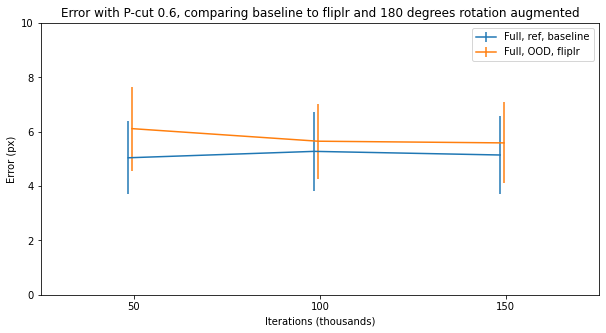

In [6]:
# in case we restarted the kernel or something, let's make
# sure deeplabcut is imported and the config_path defined
import deeplabcut

config_path = "/home/user/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/config.yaml"
model_prefix_base = 'data_augm_00_base'
model_prefix_augm = 'data_augm_01_fliplr'
Shuffles = [4,3] # let's start with the refined un-augmented, i.e. shuffle 4
trainingsetindices = [3,2]

# We need pandas for creatig a nice list to parse
import pandas as pd

import sys
sys.path.append('..') #my python file for this function is stored in the parent forlder as I'm running this
from getErrorDistribution import getErrorDistribution #import the getErrorDistribution function
import numpy as np

# Read the h5 file containing all the frames, (project_folder/training-datasets/iteration-0/UnaufmentedDataSet_project_folder/CollectedData_LabelerName.h5)
df = pd.read_hdf('/home/user/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/training-datasets/iteration-0/UnaugmentedDataSet_bat_augmentation_austin_2020_bat_dataAug18/CollectedData_DLC.h5')

image_paths = df.index.to_list() # turn dataframe into list

# get test indices
test_inds = []
for i, path in enumerate(image_paths):
    if str(path[1]).endswith("_50_test"):
        test_inds.append(i)

error_distributions_pcut = []

for shuffle, trainFractionIndex in zip(Shuffles,trainingsetindices):
   error_distributions_pcut_temp = []
   if shuffle == 4: model_prefix = model_prefix_base
   elif shuffle == 3: model_prefix = model_prefix_augm
   
   for snapshot in [0,1,2]: #we saved three snapshots, one at 50k iteratinos, one at 100k, and one at 150k
      (
            _,
            _,
            _,
            ErrorDistributionPCutOff_all,
            _,
            _
      )  = getErrorDistribution(
            config_path,
            shuffle=shuffle,
            snapindex=snapshot,
            trainFractionIndex = trainFractionIndex,
            modelprefix = model_prefix
      )
      error_distributions_pcut_temp.append(ErrorDistributionPCutOff_all.iloc[test_inds].values.flatten())
   error_distributions_pcut.append(error_distributions_pcut_temp)

error_distributions_pcut = np.array(error_distributions_pcut) # array with dimensions [shuffle, snapshot, frames]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
for shuffle in [0,1]: #we start counting at 0, so for now, let's consider each index one less
    plt.errorbar(np.array([50,100,150])-1.5+shuffle,np.nanmean(error_distributions_pcut[shuffle,:],axis=1), np.nanstd(error_distributions_pcut[shuffle,:],axis=1)/len(test_inds)**.5)

plt.xticks([50, 100, 150])
plt.xlim([25,175])
plt.ylim([0,10])
plt.title("Error with P-cut 0.6, comparing baseline to fliplr and 180 degrees rotation augmented")

plt.legend(["Full, ref, baseline", "Full, OOD, fliplr"])

plt.xlabel("Iterations (thousands)")
plt.ylabel("Error (px)")

## Interpret performance of network after "fliplr" augmentation

That is a significant improvement in accuracy. The ```fliplr``` augmentation seems to prevent the network from becoming biased to one flight direction. It is however, not quite beating the performance of the baseline refined case (shuffle4: full, Ref).

There is another augmentation that, in our case, is related to the flight direction, namely the rotation augmentation. The idea here is that in order to prevent the network from associating absolute in-image spatial orientation with positions for certain labels, we want to randomly rotate some of the training data. The degree to which this makes sense is context dependent. If you are analyzing a horse walking in a horizontal direction from the camera's point of view, large degrees of rotation make little sense as the network will never encounter a horse walking upside down. But if you are filming an animal from above, or below if the animal is flying or swimming, such that the animal is free to move in any direction, then this type of augmentation makes sense.

By default, DeepLabCut applies a 25° rotation augmentation, I tried increasing that, first to 90°, then to 180°. I will only cover the 180° case here as the 90° case is exactly the same, only with slightly worse performance.

All the steps taken are the same as before.
- Create the model prefix folder
- Change the ```pose_cfg.yaml``` file to apply the augmentation
- Train the network
- Evaluate the network performance
- Plot results


In [ ]:

# in case we restarted the kernel or something, let's make
# sure deeplabcut is imported and the config_path defined
import deeplabcut

config_path = '/home/user/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/config.yaml'

# we also need the package os for folder manipulation
import os
# and shutil for copying files
import shutil

#import tools for reading our config file
from deeplabcut.utils.auxiliaryfunctions import read_config

# Number and name for our model folder
model_number = 3 # CHANGE
modelprefix_pre = 'data_augm'
daug_str = 'max_rotate' # CHANGE

# Get config as dict and associated paths
cfg = read_config(config_path)
project_path = cfg["project_path"] # or: os.path.dirname(config_path) #dlc_models_path = os.path.join(project_path, "dlc-models")
training_datasets_path = os.path.join(project_path, "training-datasets")

# Define shuffles
shuffles = [1,2,3,4]
trainingsetindices = [0, 1, 2, 3]

# Get train and test pose config file paths from base project, for each shuffle
list_base_train_pose_config_file_paths = []
list_base_test_pose_config_file_paths = []
for shuffle_number, trainingsetindex in zip(shuffles, trainingsetindices):
    base_train_pose_config_file_path_TEMP,\
    base_test_pose_config_file_path_TEMP,\
    _ = deeplabcut.return_train_network_path(config_path,
                                            shuffle=shuffle_number,
                                            trainingsetindex=trainingsetindex)  # base_train_pose_config_file
    list_base_train_pose_config_file_paths.append(base_train_pose_config_file_path_TEMP)
    list_base_test_pose_config_file_paths.append(base_test_pose_config_file_path_TEMP)

# Create subdirs for this augmentation method
model_prefix = '_'.join([modelprefix_pre, "{0:0=2d}".format(model_number), daug_str]) # modelprefix_pre = aug_
aug_project_path = os.path.join(project_path, model_prefix)
aug_dlc_models = os.path.join(aug_project_path, "dlc-models", )

# make the folder for this modelprefix
try:
    os.mkdir(aug_project_path)
except OSError as error:
    print(error)
    print("Skipping this one as it already exists")

# Copy base train pose config file to the directory of this augmentation method
for j, (shuffle, trainingsetindex) in enumerate(zip(shuffles,trainingsetindices)):
    one_train_pose_config_file_path,\
    one_test_pose_config_file_path,\
    _ = deeplabcut.return_train_network_path(config_path,
                                            shuffle=shuffle,
                                            trainingsetindex=trainingsetindex,
                                            modelprefix=model_prefix)
    
    # make train and test directories for this subdir
    os.makedirs(str(os.path.dirname(one_train_pose_config_file_path))) # create parentdir 'train'
    os.makedirs(str(os.path.dirname(one_test_pose_config_file_path))) # create parentdir 'test
    
    # copy test and train config from base project to this subdir
    # copy base train config file
    shutil.copyfile(list_base_train_pose_config_file_paths[j],
                        one_train_pose_config_file_path) 
    # copy base test config file
    shutil.copyfile(list_base_test_pose_config_file_paths[j],
                        one_test_pose_config_file_path)


In [ ]:
#import tools for changing our config file
from deeplabcut.utils.auxiliaryfunctions import edit_config

model_prefix = 'data_augm_03_max_rotate'

## Initialise dict with additional edits to train config: optimizer
train_edits_dict = {}
dict_optimizer = {'optimizer':'adam',
    'batch_size': 8, # the gpu I'm using has plenty of memory so batch size 8 makes sense
    'multi_step': [[1e-4, 7500], [5 * 1e-5, 12000], [1e-5, 150000]]} # if no yaml file passed, initialise as an empty dict
train_edits_dict.update({'optimizer': dict_optimizer['optimizer'], #'adam',
    'batch_size': dict_optimizer['batch_size'],
    'multi_step': dict_optimizer['multi_step']})

# Augmentation edits
edits_dict = dict()
edits_dict["symmetric_pairs"] = (0, 14), (1, 12), (2, 13), (3, 11), (4, 9), (5, 10)
edits_dict["fliplr"] = True
edits_dict["rotation"] = 180

for shuffle, trainingsetindex in zip(shuffles,trainingsetindices):
    one_train_pose_config_file_path,\
    _,\
    _ = deeplabcut.return_train_network_path(config_path,
                                            shuffle=shuffle,
                                            trainingsetindex=trainingsetindex,
                                            modelprefix=model_prefix)

    edit_config(str(one_train_pose_config_file_path), edits_dict)
    edit_config(str(one_train_pose_config_file_path), train_edits_dict)


## Train network with ```fliplr``` and stronger ```rotation``` augmentation
Now let's train the network with the new augmentation. Again, this will take several hours.

In [ ]:
import deeplabcut
# define config path and model prefix
config_path='/home/user/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/config.yaml'
model_prefix = 'data_augm_03_max_rotate'

# the computer I'm working on has several gpus, here I used the third one.
gputouse=3

# define shuffles and trainingsetindices
shuffles = [1,2,3,4]
trainingsetindices = [0,1,2,3]

# loop over shuffles and train each
for shuffle, trainingsetindex in zip(shuffles, trainingsetindices):
    deeplabcut.train_network(
        config_path,
        shuffle=shuffle,
        modelprefix=model_prefix,
        gputouse=gputouse,
        trainingsetindex=trainingsetindex,
        max_snapshots_to_keep=3, # training for 150000 iterations so let's save 50, 100, and 150.
        saveiters=50000
    )

In [ ]:
# Evaluate the network
import deeplabcut

config_path = "/home/user/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/config.yaml"
model_prefix = 'data_augm_03_max_rotate'
Shuffles = [1,2,3,4]
trainingsetindices = [0,1,2,3]

#import tools for modifying our config file
from deeplabcut.utils.auxiliaryfunctions import edit_config

# make sure we are testing all snapshots
edit_config(config_path,{'snapshotindex':'all'})

for shuffle, trainingsetindex in zip(Shuffles,trainingsetindices):
    deeplabcut.evaluate_network(config_path, modelprefix = model_prefix, Shuffles = [shuffle], trainingsetindex=trainingsetindex, gputouse=3)

In [ ]:
# Get detailed error data for plotting

# in case we restarted the kernel or something, let's make
# sure deeplabcut is imported and the config_path defined
import deeplabcut

config_path = "/home/user/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/config.yaml"
model_prefix_base = 'data_augm_00_base'
model_prefix_augm = 'data_augm_03_max_rotate'
Shuffles = [4,3] # let's start with the refined un-augmented, i.e. shuffle 4
trainingsetindices = [3,2]

# We need pandas for creatig a nice list to parse
import pandas as pd

import sys
sys.path.append('..') #my python file for this function is stored in the parent forlder as I'm running this
from getErrorDistribution import getErrorDistribution #import the getErrorDistribution function
import numpy as np

# Read the h5 file containing all the frames, (project_folder/training-datasets/iteration-0/UnaufmentedDataSet_project_folder/CollectedData_LabelerName.h5)
df = pd.read_hdf('/home/user/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/training-datasets/iteration-0/UnaugmentedDataSet_bat_augmentation_austin_2020_bat_dataAug18/CollectedData_DLC.h5')

image_paths = df.index.to_list() # turn dataframe into list

# get test indices
test_inds = []
for i, path in enumerate(image_paths):
    if str(path[1]).endswith("_50_test"):
        test_inds.append(i)

error_distributions_pcut = []

for shuffle, trainFractionIndex in zip(Shuffles,trainingsetindices):
   error_distributions_pcut_temp = []
   if shuffle == 4: model_prefix = model_prefix_base
   elif shuffle == 3: model_prefix = model_prefix_augm
   
   for snapshot in [0,1,2]: #we saved three snapshots, one at 50k iteratinos, one at 100k, and one at 150k
      (
            _,
            _,
            _,
            ErrorDistributionPCutOff_all,
            _,
            _
      )  = getErrorDistribution(
            config_path,
            shuffle=shuffle,
            snapindex=snapshot,
            trainFractionIndex = trainFractionIndex,
            modelprefix = model_prefix
      )
      error_distributions_pcut_temp.append(ErrorDistributionPCutOff_all.iloc[test_inds].values.flatten())
   error_distributions_pcut.append(error_distributions_pcut_temp)

error_distributions_pcut = np.array(error_distributions_pcut) # array with dimensions [shuffle, snapshot, frames]

Text(0, 0.5, 'Error (px)')

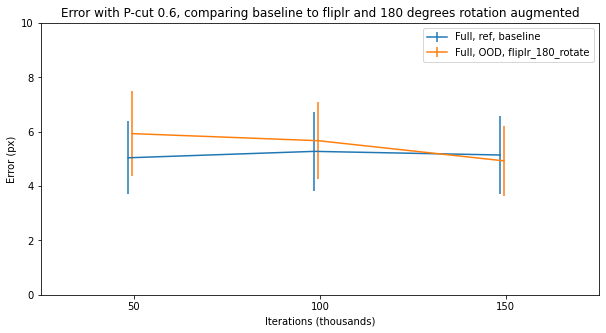

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

for shuffle in [0,1]: #we start counting at 0, so for now, let's consider each index one less
    plt.errorbar(np.array([50,100,150])-1.5+shuffle,np.nanmean(error_distributions_pcut[shuffle,:],axis=1), np.nanstd(error_distributions_pcut[shuffle,:],axis=1)/len(test_inds)**.5)

plt.xticks([50, 100, 150])
plt.xlim([25,175])
plt.ylim([0,10])
plt.title("Error with P-cut 0.6, comparing baseline to fliplr and 180 degrees rotation augmented")

plt.legend(["Full, ref, baseline", "Full, OOD, fliplr_180_rotate"])

plt.xlabel("Iterations (thousands)")
plt.ylabel("Error (px)")

With this, it appears that we have reached our goal, which was **to use augmentation to match or beat the accuracy of refining**. But let's also take a look at the accuracy per video. I will also plot the baseline, un-refined full network accuracy here to highlight how much the augmentation has improved the performance of the network.

This net has already been evaluated!
This net has already been evaluated!
This net has already been evaluated!


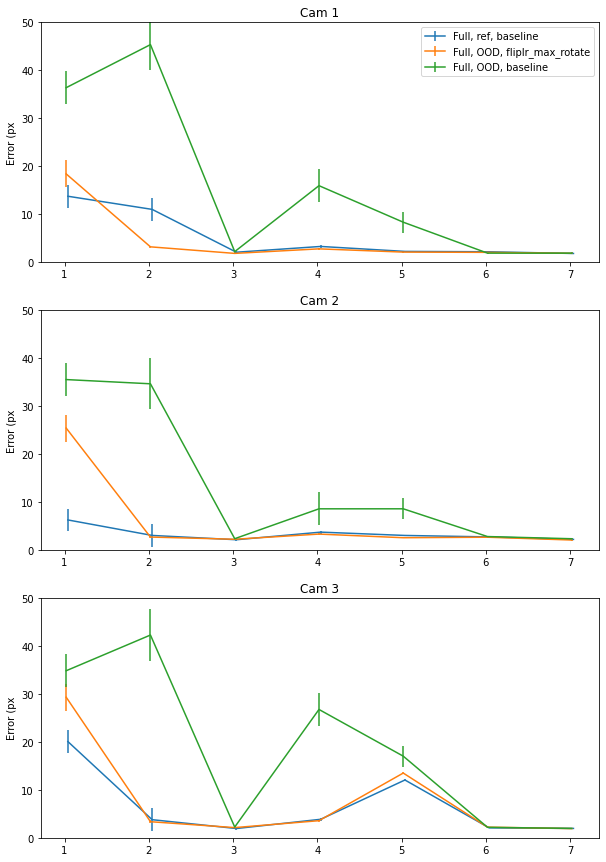

In [170]:
# in case we restarted the kernel or something, let's make
# sure deeplabcut is imported and the config_path defined
import deeplabcut

config_path = "/home/user/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/config.yaml"
model_prefix_base = 'data_augm_00_base'
model_prefix_augm = 'data_augm_03_max_rotate'
Shuffles = [4,3,3]
trainingsetindices = [3,2,2]

# We need pandas for creatig a nice list to parse
import pandas as pd

import sys
sys.path.append('..') #my python file for this function is stored in the parent forlder as I'm running this
from getErrorDistribution import getErrorDistribution #import the getErrorDistribution function
import numpy as np

# Read the h5 file containing all the frames, (project_folder/training-datasets/iteration-0/UnaufmentedDataSet_project_folder/CollectedData_LabelerName.h5)
df = pd.read_hdf('/home/juser/projects/bat_augmentation_austin_2020_bat_data-DLC-2022-08-18/training-datasets/iteration-0/UnaugmentedDataSet_bat_augmentation_austin_2020_bat_dataAug18/CollectedData_DLC.h5')

image_paths = df.index.to_list() # turn dataframe into list

# get test indices
test_inds = []
for i, path in enumerate(image_paths):
    if str(path[1]).endswith("_50_test"):
        test_inds.append(i)

# this gives us the paths of our 27 test videos
test_paths = list(set([image_paths[i][1] for i in test_inds]))

#%% sorted so that the corresponding videos have the same index in three lists (one per camera)
test_paths_cam1 =   ['TS5-544-Cam1_2020-06-25_000099Track8_50_test',
                    'TS5-544-Cam1_2020-06-25_000103Track3_50_test',
                    'TS5-544-Cam1_2020-06-25_000104Track3_50_test',
                    'TS5-544-Cam1_2020-06-25_000108Track6_50_test',
                    'TS5-544-Cam1_2020-06-25_000123Track6_50_test',
                    'TS5-544-Cam1_2020-06-25_000128Track2_50_test',
                    'TS5-544-Cam1_2020-06-25_000134Track5_50_test'
                    ]
test_paths_cam2 =   ['IL5-519-Cam2_2020-06-25_000099Track6_50_test',
                    'IL5-519-Cam2_2020-06-25_000103Track3_50_test',
                    'IL5-519-Cam2_2020-06-25_000104Track2_50_test',
                    'IL5-519-Cam2_2020-06-25_000109Track1_50_test',
                    'IL5-519-Cam2_2020-06-25_000124Track9_50_test',
                    'IL5-519-Cam2_2020-06-25_000130Track2_50_test',
                    'IL5-519-Cam2_2020-06-25_000136Track10_50_test'
                    ]
test_paths_cam3 =   ['IL5-534-Cam3_2020-06-25_000095Track14_50_test',
                    'IL5-534-Cam3_2020-06-25_000100Track4_50_test',
                    'IL5-534-Cam3_2020-06-25_000101Track4_50_test',
                    'IL5-534-Cam3_2020-06-25_000106Track3_50_test',
                    'IL5-534-Cam3_2020-06-25_000122Track7_50_test',
                    'IL5-534-Cam3_2020-06-25_000127Track4_50_test',
                    'IL5-534-Cam3_2020-06-25_000133Track9_50_test'
                    ]

nvideos = 7 # number of videos

# get test frame indexes per camera
test_inds_cam1 = [[],[],[],[],[],[],[]]
test_inds_cam2 = [[],[],[],[],[],[],[]]
test_inds_cam3 = [[],[],[],[],[],[],[]]

for i, path in enumerate(image_paths):
    for j in range(nvideos):
        if str(path[1]).__eq__(test_paths_cam1[j]):
            test_inds_cam1[j].append(i)
        elif str(path[1]).__eq__(test_paths_cam2[j]):
            test_inds_cam2[j].append(i)
        elif str(path[1]).__eq__(test_paths_cam3[j]):
            test_inds_cam3[j].append(i)

nshuffles = len(Shuffles)

#pre-allocate matrixes for mean values and standard errors
mean_cam1 = np.zeros([nshuffles,nvideos]) # shuffle x movie
mean_cam2 = np.zeros([nshuffles,nvideos])
mean_cam3 = np.zeros([nshuffles,nvideos])

ste_cam1 = np.zeros([nshuffles,nvideos])
ste_cam2 = np.zeros([nshuffles,nvideos])
ste_cam3 = np.zeros([nshuffles,nvideos])

meanPcut_cam1 = np.zeros([nshuffles,nvideos]) # shuffle x movie
meanPcut_cam2 = np.zeros([nshuffles,nvideos])
meanPcut_cam3 = np.zeros([nshuffles,nvideos])

stePcut_cam1 = np.zeros([nshuffles,nvideos])
stePcut_cam2 = np.zeros([nshuffles,nvideos])
stePcut_cam3 = np.zeros([nshuffles,nvideos])

# %%

for i, shuffle in enumerate(Shuffles):
    if shuffle == 4 or i == 2: model_prefix = model_prefix_base
    elif shuffle == 3: model_prefix = model_prefix_augm 

    trainFractionIndex = shuffle-1
    snapshot=-1
    (
        ErrorDistribution_all,
        _,
        _,
        ErrorDistributionPCutOff_all,
        _,
        _
    )  = getErrorDistribution(
        config_path,
        shuffle=shuffle,
        snapindex=snapshot,
        trainFractionIndex = trainFractionIndex,
        modelprefix = model_prefix
    )
    for movie_number in range(7):

        meanPcut_cam1[i,movie_number] = np.nanmean(ErrorDistributionPCutOff_all.values[test_inds_cam1[movie_number]][:])
        stePcut_cam1[i,movie_number] = np.nanstd(ErrorDistributionPCutOff_all.values[test_inds_cam1[movie_number]][:])/(ErrorDistribution_all.values[test_inds_cam1[movie_number]][:].size**.5)

        meanPcut_cam2[i,movie_number] = np.nanmean(ErrorDistributionPCutOff_all.values[test_inds_cam2[movie_number]][:])
        stePcut_cam2[i,movie_number] = np.nanstd(ErrorDistributionPCutOff_all.values[test_inds_cam1[movie_number]][:])/(ErrorDistribution_all.values[test_inds_cam2[movie_number]][:].size**.5)

        meanPcut_cam3[i,movie_number] = np.nanmean(ErrorDistributionPCutOff_all.values[test_inds_cam3[movie_number]][:])
        stePcut_cam3[i,movie_number] = np.nanstd(ErrorDistributionPCutOff_all.values[test_inds_cam1[movie_number]][:])/(ErrorDistribution_all.values[test_inds_cam3[movie_number]][:].size**.5)

fig, (ax1,ax2,ax3) = plt.subplots(3,1)
fig.set_figheight(15)
fig.set_figwidth(10)
for i, shuffle in enumerate(Shuffles):
    
    # to jitter the error bars to keep  them from overlapping
    movie_number = list(range(1,8))
    movie_number = [x - 2/50 + shuffle/50 for x in movie_number]
    
    ax1.errorbar(movie_number,meanPcut_cam1[i,:], stePcut_cam1[i,:,])

    ax2.errorbar(movie_number,meanPcut_cam2[i,:], stePcut_cam2[i,:,])

    ax3.errorbar(movie_number,meanPcut_cam3[i,:], stePcut_cam3[i,:,])

ax1.set_ylim([0, 50])
ax2.set_ylim([0, 50])
ax3.set_ylim([0, 50])
ax1.set_title("Cam 1")
ax2.set_title("Cam 2")
ax3.set_title("Cam 3")
ax1.set_ylabel("Error (px")
ax2.set_ylabel("Error (px")
ax3.set_ylabel("Error (px")
ax1.legend(["Full, ref, baseline", "Full, OOD, fliplr_180_rotate", "Full, OOD, baseline"])


## Interpret performance of network after ```fliplr``` and 180° rotation augmentation
The results look very promising. Video 1 keeps being difficult. This is likely due to this video depicting a bat flying in a manner that is atypical for the dataset used here. Most videos in the dataset depict rather straight-forward flybys, but video 1 shows a bat slowly ascending while turning. Even so, the augmentation has lowered the pixel error for video 1 compared to the baseline, and for all other videos, the augmentation has led to performance close to, or better than, the refined case.

# Conclusion
What follows are some of my conclusions from using augmentation to improve performance when tracking wing movement of bats using DeepLabCut.

## Where scalability is not important, consider refining
We saw from our baseline accuracy tests that when refining, there was no gain from increasing the ammount of base training data. In practical terms this means that if you know which videos you want to analyze, and when you do not plan on using the network for analyzing other videos in the future, then it makes sense to prioritize digitizing frames from the videos to be analyzed.

## Inspect bodypart predictions and augment with purpose
At first, I tried a couple of permutations of different image augmentations and saw no or little performance improvement. I tried augmentations related to scale, brightness, blurriness, and probably some other that slip my mind at the moment. I more or less concluded that augmentations have little effect and that for a given set of training and test data, DeepLabCut's default training parameters are close to optimal and little can be gained by augmenting the training data. But then I looked closer at the labeled frames from ```evaluate_network``` and realized that the high pixel errors were mainly caused by the network getting left and right mixed up and augmented accordingly. Doing that, I saw an average accuracy improvement of more than 10 pixels. For this dataset, 10 pixels is quite big, for comparison, on the largest image in the test dataset, the forearm of the bat is less than 70 pixels long.

